In [1]:
# ============================================================
# Setup and Directory Management
# ============================================================
import os
import sys
from pathlib import Path

# Check current directory
print(f"Current directory: {os.getcwd()}")

# If we're in the notebook directory, move to project root
if 'notebook' in os.getcwd():
    os.chdir('../')
    print(f"Changed to: {os.getcwd()}")

Current directory: c:\09_AHFID\CervicalAI-Screen\notebook
Changed to: c:\09_AHFID\CervicalAI-Screen


In [2]:
# ============================================================
# Import Required Libraries
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import numpy as np
import json
import random
from pathlib import Path
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import time
import timm
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Libraries imported successfully")

c:\09_AHFID\CervicalAI-Screen\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [3]:
# ============================================================
# Define Model Architecture (Compatible with Existing Checkpoint)
# ============================================================
class SSLEfficientNet(nn.Module):
    def __init__(self, model_name='efficientnet_b0', num_classes=2, dropout_rate=0.3):
        super(SSLEfficientNet, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.feature_dim = self.backbone.num_features
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 256), nn.ReLU(inplace=True), nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Linear(128, 64))
        self.classifier = nn.Sequential(nn.Dropout(dropout_rate), nn.Linear(self.feature_dim, 256), nn.ReLU(inplace=True), nn.Dropout(dropout_rate * 0.5), nn.Linear(256, num_classes))
        self._initialize_weights()
    def _initialize_weights(self):
        for m in [self.projector, self.classifier]:
            for layer in m:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)
    def forward(self, x): return self.classifier(self.backbone(x))

def create_model(num_classes=2, model_name='efficientnet_b0', dropout_rate=0.3):
    return SSLEfficientNet(model_name=model_name, num_classes=num_classes, dropout_rate=dropout_rate)

print("Model architecture defined")

Model architecture defined


In [4]:
# ============================================================
# Custom Loss Functions
# ============================================================
class FocalLoss(nn.Module):
    """
    A more stable and effective loss function for handling class imbalance and focusing 
    on hard-to-classify examples. It replaces the previous volatile combined loss.
    - alpha: Balances the importance of positive vs. negative classes. A high value
             (e.g., 0.85) makes the model pay much more attention to the positive class.
    - gamma: Focuses the model's attention on examples it gets wrong.
    """
    def __init__(self, alpha=0.85, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        
        # Create a tensor for alpha values based on the target class
        alpha_t = torch.full_like(targets, 1 - self.alpha, dtype=torch.float)
        alpha_t[targets == 1] = self.alpha
        
        focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        else:
            return focal_loss.sum()

print("Balanced loss functions defined")

Balanced loss functions defined


In [5]:
# ============================================================
# Dataset and Transform Definitions
# ============================================================
class LabeledDataset(Dataset):
    def __init__(self, paths, labels, transform_map): self.paths, self.labels, self.tm = paths, labels, transform_map
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        label = self.labels[idx]
        return self.tm[label](img), label

class UnlabeledDataset(Dataset):
    def __init__(self, paths, weak_tf, strong_tf): self.paths, self.weak_tf, self.strong_tf = paths, weak_tf, strong_tf
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.weak_tf(img), self.strong_tf(img)

class ValidationDataset(Dataset):
    def __init__(self, paths, labels, transform): self.paths, self.labels, self.tf = paths, labels, transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.tf(img), self.labels[idx]

norm_params = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
strong_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30), transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(), transforms.Normalize(**norm_params)
])
moderate_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(), transforms.Normalize(**norm_params)
])
weak_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(), transforms.Normalize(**norm_params)
])
val_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(**norm_params)])

print("SSL Datasets and transforms defined")

SSL Datasets and transforms defined


In [6]:
# ============================================================
# Data Loading Function
# ============================================================
def load_and_prepare_data():
    ARTIFACTS_DIR = Path("artifacts")
    with open(ARTIFACTS_DIR / "data_metadata.json", "r") as f: data_metadata = json.load(f)
    data_dir = Path(data_metadata["data_dir"])
    labeled_dir, unlabeled_dir = data_dir / "labeled", data_dir / "unlabeled"
    
    labeled_paths, labels = [], []
    for name, idx in {"Negative": 0, "Positive": 1}.items():
        class_dir = labeled_dir / name
        if class_dir.exists():
            for path in class_dir.glob("*.[jp][pn]g"): labeled_paths.append(str(path)); labels.append(idx)
    
    unlabeled_paths = [str(p) for p in unlabeled_dir.glob("*.[jp][pn]g")] if unlabeled_dir.exists() else []
    print(f"Loaded {len(labeled_paths)} labeled ({Counter(labels)}) and {len(unlabeled_paths)} unlabeled images.")
    
    train_paths, val_paths, train_labels, val_labels = train_test_split(labeled_paths, labels, test_size=0.2, random_state=SEED, stratify=labels)
    
    train_dataset = LabeledDataset(train_paths, train_labels, transform_map={0: moderate_transform, 1: strong_transform})
    val_dataset = ValidationDataset(val_paths, val_labels, val_transform)
    unlabeled_dataset = UnlabeledDataset(unlabeled_paths, weak_transform, strong_transform)
    
    return train_dataset, val_dataset, unlabeled_dataset, train_labels

print("Data loading function defined")

Data loading function defined


In [7]:
# ============================================================
# Two-Stage Trainer Class
# ============================================================
class TwoStageTrainer:
    def __init__(self, model, device='cuda', ssl_weight=1.5, confidence_thresh=0.9):
        self.model, self.device = model.to(device), device
        # MODIFIED: Use the new, more stable FocalLoss
        self.criterion = FocalLoss(alpha=0.85, gamma=2.0)
        self.ssl_weight, self.confidence_thresh = ssl_weight, confidence_thresh
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-3)
        # MODIFIED: Scheduler will be initialized in the train method
        self.scheduler = None 
        self.history = {'train_loss': [], 'consistency_loss': [], 'sensitivity': [], 'specificity': [], 'false_negatives': [], 'false_positives': []}
        self.best_fn_count = float('inf')
        self.best_fp_at_best_fn = float('inf')

    def train_epoch(self, labeled_loader, unlabeled_loader, epoch, stage):
        self.model.train()
        if stage == 2:
            for param in self.model.backbone.parameters(): param.requires_grad = False
        
        total_sup_loss, total_cons_loss = 0, 0
        unlabeled_iter = iter(unlabeled_loader)
        pbar = tqdm(labeled_loader, desc=f'Stage {stage} - Epoch {epoch+1}')
        
        for labeled_images, labels in pbar:
            labeled_images, labels = labeled_images.to(self.device), labels.to(self.device)
            logits_l = self.model(labeled_images)
            sup_loss = self.criterion(logits_l, labels)
            
            try: images_u_w, images_u_s = next(unlabeled_iter)
            except StopIteration: unlabeled_iter = iter(unlabeled_loader); images_u_w, images_u_s = next(unlabeled_iter)
            images_u_w, images_u_s = images_u_w.to(self.device), images_u_s.to(self.device)
            
            with torch.no_grad():
                logits_u_w = self.model(images_u_w)
                max_probs, p_targets = torch.max(F.softmax(logits_u_w, dim=1), dim=1)
                mask = max_probs.ge(self.confidence_thresh).float()
            
            logits_u_s = self.model(images_u_s)
            cons_loss = (F.cross_entropy(logits_u_s, p_targets, reduction='none') * mask).mean()
            total_loss = sup_loss + self.ssl_weight * cons_loss
            
            self.optimizer.zero_grad(); total_loss.backward(); self.optimizer.step()
            total_sup_loss += sup_loss.item(); total_cons_loss += cons_loss.item()
            pbar.set_postfix({'sup_loss': f'{sup_loss.item():.3f}', 'cons_loss': f'{cons_loss.item():.3f}'})
        
        return total_sup_loss / len(labeled_loader), total_cons_loss / len(labeled_loader)

    def validate_and_find_threshold(self, val_loader, target_fn=0):
        self.model.eval()
        all_probs, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                logits = self.model(images.to(self.device))
                all_probs.extend(F.softmax(logits, dim=1)[:, 1].cpu().numpy())
                all_labels.extend(labels.numpy())
        all_probs, all_labels = np.array(all_probs), np.array(all_labels)
        
        best_threshold, best_fp = 0.5, float('inf')
        candidate_thresholds = [t for t in np.arange(0.01, 1.0, 0.01) if np.sum((all_labels == 1) & (all_probs < t)) <= target_fn]
        
        if not candidate_thresholds:
            min_fn_achieved = np.inf; best_thresholds_for_min_fn = []
            for t in np.arange(0.01, 1.0, 0.01):
                fn = np.sum((all_labels == 1) & (all_probs < t))
                if fn < min_fn_achieved:
                    min_fn_achieved, best_thresholds_for_min_fn = fn, [t]
                elif fn == min_fn_achieved:
                    best_thresholds_for_min_fn.append(t)
            candidate_thresholds = best_thresholds_for_min_fn
        
        for threshold in candidate_thresholds:
            fp = np.sum((all_labels == 0) & (all_probs >= threshold))
            if fp < best_fp: best_fp, best_threshold = fp, threshold
        
        y_pred = (all_probs >= best_threshold).astype(int)
        tp = np.sum((y_pred == 1) & (all_labels == 1)); fn = np.sum((y_pred == 0) & (all_labels == 1))
        tn = np.sum((y_pred == 0) & (all_labels == 0)); fp = np.sum((y_pred == 1) & (all_labels == 0))
        
        metrics = {'sensitivity': tp/(tp+fn) if tp+fn>0 else 0, 'specificity': tn/(tn+fp) if tn+fp>0 else 0, 'false_negatives': fn, 'false_positives': fp}
        return metrics, best_threshold

    def train(self, labeled_loader, unlabeled_loader, val_loader, total_epochs=50, stage1_epochs=15):
        # MODIFIED: Use a more stable CosineAnnealingLR scheduler
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=total_epochs, eta_min=1e-6)
        patience, max_patience = 0, 15 # Increased patience slightly

        for stage in [1, 2]:
            print(f"\\n{'='*25} STAGE {stage} {'='*25}")
            epochs_in_stage = stage1_epochs if stage == 1 else total_epochs - stage1_epochs
            
            for epoch in range(epochs_in_stage):
                train_loss, cons_loss = self.train_epoch(labeled_loader, unlabeled_loader, epoch, stage)
                metrics, threshold = self.validate_and_find_threshold(val_loader, target_fn=0)
                self.scheduler.step()
                
                for key, val in metrics.items(): self.history[key].append(val)
                self.history['train_loss'].append(train_loss); self.history['consistency_loss'].append(cons_loss)

                print(f"Epoch {epoch+1}/{epochs_in_stage} (Stage {stage}) | Sens: {metrics['sensitivity']:.3f}, Spec: {metrics['specificity']:.3f}, FN: {metrics['false_negatives']}, FP: {metrics['false_positives']}, Thr: {threshold:.3f}")

                is_best = False
                # MODIFIED: Only save a model if specificity is reasonably high
                if metrics['specificity'] >= 0.85:
                    if metrics['false_negatives'] < self.best_fn_count or \
                       (metrics['false_negatives'] == self.best_fn_count and metrics['false_positives'] < self.best_fp_at_best_fn):
                        is_best = True

                if is_best:
                    self.best_fn_count, self.best_fp_at_best_fn, patience = metrics['false_negatives'], metrics['false_positives'], 0
                    checkpoint = {'epoch': epoch, 'model_state_dict': self.model.state_dict(),
                                  'optimizer_state_dict': self.optimizer.state_dict(), 'metrics': metrics, 
                                  'threshold': threshold, 'history': self.history}
                    torch.save(checkpoint, 'artifacts/balanced_sensitivity_model.pth')
                    print(f"  ✓ Saved best model (FN: {metrics['false_negatives']}, FP: {metrics['false_positives']})")
                else:
                    patience += 1
                
                if (patience >= max_patience and stage == 2) or (self.best_fn_count == 0 and self.best_fp_at_best_fn <= 2):
                    print(f"\\n{'✓ CLINICAL TARGET MET' if (self.best_fn_count == 0 and self.best_fp_at_best_fn <= 2) else 'Early stopping'}!")
                    return self.history
        
        print("\\n" + "="*60); print("TRAINING COMPLETED"); print(f"Best Results: FN={self.best_fn_count}, FP={self.best_fp_at_best_fn}"); print("="*60)
        return self.history

print("Two-Stage Trainer defined")

Two-Stage Trainer defined


In [8]:
# ============================================================
# Visualization Functions (Updated)
# ============================================================
def plot_training_history(history):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Two-Stage SSL Balanced Sensitivity Training', fontsize=16, fontweight='bold')
    
    axes[0, 0].plot(history['train_loss'], label='Supervised Loss'); axes[0, 0].plot(history['consistency_loss'], label='Consistency Loss', linestyle='--');
    axes[0, 0].set_title('Loss Components'); axes[0, 0].legend()
    
    axes[0, 1].plot(history['sensitivity'], label='Sensitivity', color='g'); axes[0, 1].plot(history['specificity'], label='Specificity', color='b');
    axes[0, 1].set_title('Sensitivity vs Specificity'); axes[0, 1].legend()

    axes[0, 2].plot(history['false_negatives'], label='False Negatives', color='r', marker='o'); axes[0, 2].plot(history['false_positives'], label='False Positives', color='orange', marker='s');
    axes[0, 2].set_title('Error Counts'); axes[0, 2].legend()
    
    for ax in axes.flat: ax.set_xlabel('Epoch'); ax.grid(True, alpha=0.3)
    
    # Add summary text instead of empty plots
    summary_text = f"""
    FINAL MODEL PERFORMANCE
    -----------------------
    Best False Negatives Achieved: {min(history['false_negatives'])}
    Final False Positives: {history['false_positives'][-1]}
    
    Final Sensitivity: {history['sensitivity'][-1]:.3f}
    Final Specificity: {history['specificity'][-1]:.3f}
    """
    axes[1, 0].text(0.5, 0.5, summary_text, ha='center', va='center', fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')
    axes[1, 2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('artifacts/balanced_sensitivity_training_history.png', dpi=150)
    plt.show()

print("Visualization functions defined")

Visualization functions defined


In [9]:
# ============================================================
# Main Training Pipeline & Helper Functions
# ============================================================
def convert_numpy_to_python(obj):
    if isinstance(obj, np.integer): return int(obj)
    if isinstance(obj, np.floating): return float(obj)
    if isinstance(obj, np.ndarray): return obj.tolist()
    if isinstance(obj, dict): return {k: convert_numpy_to_python(v) for k, v in obj.items()}
    if isinstance(obj, list): return [convert_numpy_to_python(item) for item in obj]
    return obj

def main():
    """Main two-stage semi-supervised training pipeline"""
    print("="*60)
    print("SEMI-SUPERVISED LEARNING (TWO-STAGE) FOR OPTIMAL BALANCE")
    print("="*60)
    
    ARTIFACTS_DIR = Path("artifacts")
    with open(ARTIFACTS_DIR / "model_config.json", "r") as f: model_config = json.load(f)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    train_dataset, val_dataset, unlabeled_dataset, train_labels = load_and_prepare_data()
    
    class_counts = np.bincount(train_labels); class_weights = 1.0 / class_counts
    sample_weights = np.array([class_weights[label] for label in train_labels])
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    
    labeled_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=True)

    print(f"\nData loader summary: Labeled Batches: {len(labeled_loader)}, Unlabeled Batches: {len(unlabeled_loader)}")
    
    model = create_model(num_classes=2, dropout_rate=0.3)
    pretrained_path = ARTIFACTS_DIR / "ssl_model_best_010_78.9.pth"
    if pretrained_path.exists():
        print(f"Loading pretrained weights from: {pretrained_path}")
        checkpoint = torch.load(pretrained_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        print("✓ Pretrained weights loaded")
    
    trainer = TwoStageTrainer(model, device=device, ssl_weight=1.5, confidence_thresh=0.90)
    history = trainer.train(labeled_loader, unlabeled_loader, val_loader, total_epochs=50, stage1_epochs=15)
    
    plot_training_history(history)
    
    # MODIFIED: Filename changed
    history_serializable = convert_numpy_to_python(history)
    with open(ARTIFACTS_DIR / "balanced_sensitivity_training_history.json", "w") as f:
        json.dump(history_serializable, f, indent=2)
    
    print("\n" + "="*60)
    print("TRAINING COMPLETED SUCCESSFULLY")
    print("="*60)
    print(f"Model saved to: artifacts/balanced_sensitivity_model.pth")
    print(f"History saved to: artifacts/balanced_sensitivity_training_history.json")
    print(f"Plots saved to: artifacts/balanced_sensitivity_training_history.png")
    
    return trainer, history

SEMI-SUPERVISED LEARNING (TWO-STAGE) FOR OPTIMAL BALANCE
Using device: cpu
Loaded 190 labeled (Counter({1: 98, 0: 92})) and 6377 unlabeled images.

Data loader summary: Labeled Batches: 10, Unlabeled Batches: 100
Loading pretrained weights from: artifacts\ssl_model_best_010_78.9.pth
✓ Pretrained weights loaded
\n========================= STAGE 1 =========================


Stage 1 - Epoch 1: 100%|██████████| 10/10 [03:52<00:00, 23.21s/it, sup_loss=0.002, cons_loss=0.039]


Epoch 1/15 (Stage 1) | Sens: 0.950, Spec: 0.111, FN: 1, FP: 16, Thr: 0.010


Stage 1 - Epoch 2: 100%|██████████| 10/10 [03:45<00:00, 22.56s/it, sup_loss=0.004, cons_loss=0.083]


Epoch 2/15 (Stage 1) | Sens: 0.650, Spec: 0.667, FN: 7, FP: 6, Thr: 0.010


Stage 1 - Epoch 3: 100%|██████████| 10/10 [03:29<00:00, 20.99s/it, sup_loss=0.001, cons_loss=0.076]


Epoch 3/15 (Stage 1) | Sens: 0.450, Spec: 0.889, FN: 11, FP: 2, Thr: 0.010
  ✓ Saved best model (FN: 11, FP: 2)


Stage 1 - Epoch 4: 100%|██████████| 10/10 [03:34<00:00, 21.40s/it, sup_loss=0.001, cons_loss=0.115]


Epoch 4/15 (Stage 1) | Sens: 0.350, Spec: 1.000, FN: 13, FP: 0, Thr: 0.010


Stage 1 - Epoch 5: 100%|██████████| 10/10 [03:41<00:00, 22.18s/it, sup_loss=0.044, cons_loss=0.100]


Epoch 5/15 (Stage 1) | Sens: 0.250, Spec: 1.000, FN: 15, FP: 0, Thr: 0.010


Stage 1 - Epoch 6: 100%|██████████| 10/10 [03:48<00:00, 22.89s/it, sup_loss=0.056, cons_loss=0.096]


Epoch 6/15 (Stage 1) | Sens: 0.150, Spec: 1.000, FN: 17, FP: 0, Thr: 0.010


Stage 1 - Epoch 7: 100%|██████████| 10/10 [03:48<00:00, 22.82s/it, sup_loss=0.062, cons_loss=0.055]


Epoch 7/15 (Stage 1) | Sens: 0.050, Spec: 1.000, FN: 19, FP: 0, Thr: 0.010


Stage 1 - Epoch 8: 100%|██████████| 10/10 [03:58<00:00, 23.85s/it, sup_loss=0.001, cons_loss=0.046]


Epoch 8/15 (Stage 1) | Sens: 0.050, Spec: 1.000, FN: 19, FP: 0, Thr: 0.010


Stage 1 - Epoch 9: 100%|██████████| 10/10 [03:44<00:00, 22.42s/it, sup_loss=0.034, cons_loss=0.121]


Epoch 9/15 (Stage 1) | Sens: 0.050, Spec: 1.000, FN: 19, FP: 0, Thr: 0.010


Stage 1 - Epoch 10: 100%|██████████| 10/10 [03:44<00:00, 22.47s/it, sup_loss=0.009, cons_loss=0.119]


Epoch 10/15 (Stage 1) | Sens: 0.050, Spec: 1.000, FN: 19, FP: 0, Thr: 0.010


Stage 1 - Epoch 11: 100%|██████████| 10/10 [04:00<00:00, 24.01s/it, sup_loss=0.000, cons_loss=0.094]


Epoch 11/15 (Stage 1) | Sens: 0.050, Spec: 1.000, FN: 19, FP: 0, Thr: 0.010


Stage 1 - Epoch 12: 100%|██████████| 10/10 [03:43<00:00, 22.34s/it, sup_loss=0.000, cons_loss=0.183]


Epoch 12/15 (Stage 1) | Sens: 0.050, Spec: 1.000, FN: 19, FP: 0, Thr: 0.010


Stage 1 - Epoch 13: 100%|██████████| 10/10 [03:44<00:00, 22.46s/it, sup_loss=0.000, cons_loss=0.162]


Epoch 13/15 (Stage 1) | Sens: 0.050, Spec: 1.000, FN: 19, FP: 0, Thr: 0.010


Stage 1 - Epoch 14: 100%|██████████| 10/10 [03:42<00:00, 22.23s/it, sup_loss=0.000, cons_loss=0.123]


Epoch 14/15 (Stage 1) | Sens: 0.050, Spec: 1.000, FN: 19, FP: 0, Thr: 0.010


Stage 1 - Epoch 15: 100%|██████████| 10/10 [03:39<00:00, 21.93s/it, sup_loss=0.009, cons_loss=0.064]


Epoch 15/15 (Stage 1) | Sens: 0.000, Spec: 1.000, FN: 20, FP: 0, Thr: 0.010
\n========================= STAGE 2 =========================


Stage 2 - Epoch 1: 100%|██████████| 10/10 [01:52<00:00, 11.24s/it, sup_loss=0.005, cons_loss=0.084]


Epoch 1/35 (Stage 2) | Sens: 0.050, Spec: 1.000, FN: 19, FP: 0, Thr: 0.010


Stage 2 - Epoch 2: 100%|██████████| 10/10 [02:10<00:00, 13.04s/it, sup_loss=0.000, cons_loss=0.044]


Epoch 2/35 (Stage 2) | Sens: 0.000, Spec: 1.000, FN: 20, FP: 0, Thr: 0.010


Stage 2 - Epoch 3: 100%|██████████| 10/10 [02:40<00:00, 16.05s/it, sup_loss=0.000, cons_loss=0.064]


Epoch 3/35 (Stage 2) | Sens: 0.000, Spec: 1.000, FN: 20, FP: 0, Thr: 0.010
\nEarly stopping!


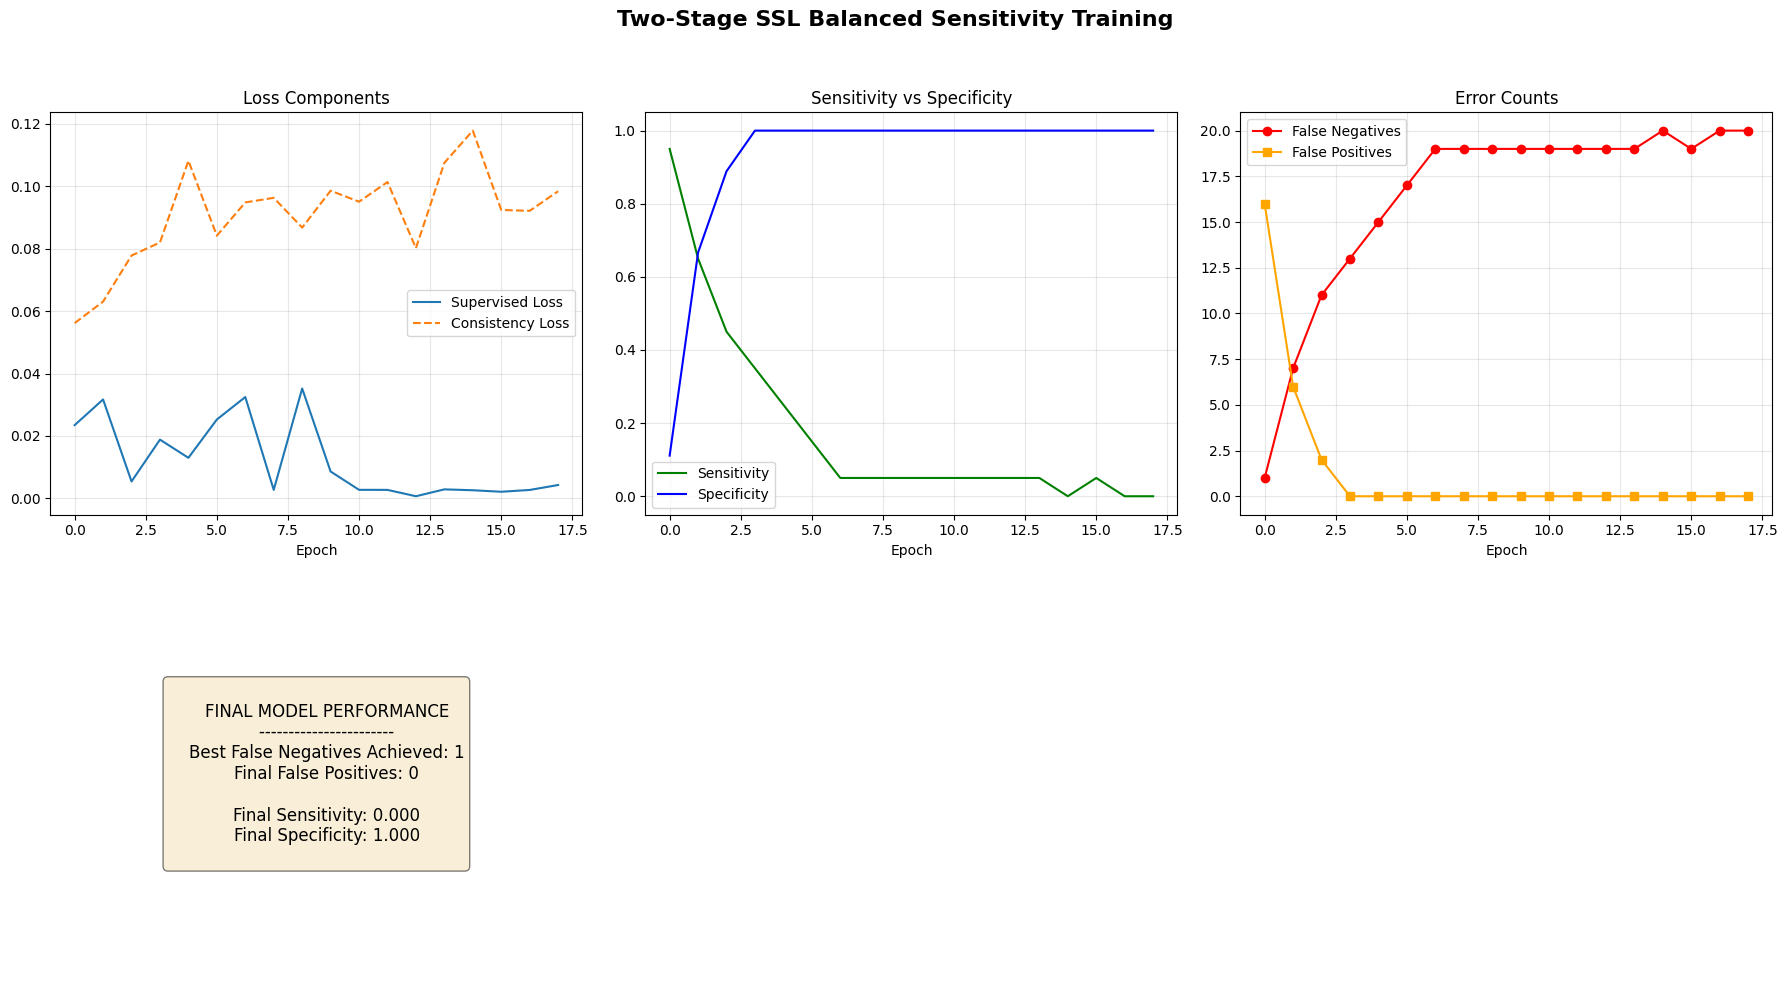


TRAINING COMPLETED SUCCESSFULLY
Model saved to: artifacts/balanced_sensitivity_model.pth
History saved to: artifacts/balanced_sensitivity_training_history.json
Plots saved to: artifacts/balanced_sensitivity_training_history.png


In [10]:
# ============================================================
# Execute Training
# ============================================================
if __name__ == "__main__":
    trainer, history = main()